In [1]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Reinforcement_learning/DQN')

In [2]:
!pip install gym-bit-flip

  Created wheel for gym-bit-flip: filename=gym_bit_flip-0.0.8-cp36-none-any.whl size=2419 sha256=b30ded0bc30e01a6ec6d7b9bc6a0f673340fa030d615fe26e3cba026bed37faf
  Stored in directory: /root/.cache/pip/wheels/4e/ef/db/838ea6ba60c0ad3439c1cd497ae47498b2537d2f0ff414a09a
Successfully built gym-bit-flip


In [3]:
from scheduler import LinearScheduler
from replay_buffer import ReplayBuffer, PrioritizedReplayBuffer

In [4]:
import numpy as np
import datetime
from collections import deque
import gym
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow import keras
from matplotlib import pyplot as plt

In [5]:
def get_network():
    input = layers.Input(shape=(n_states*2,))
    x = input
    # x = layers.Dense(units=256, activation='relu', kernel_initializer=keras.initializers.he_normal())(x)
    x = layers.Dense(units=256, activation='relu', kernel_initializer=keras.initializers.he_normal())(x)

    output = layers.Dense(units=n_actions, activation='linear')(x)
    return models.Model(input, output)


def generate_action(state, epsilon):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_network.predict(np.expand_dims(state, 0)))
    return action


def learn(beta=0):
    states, actions, rewards, next_states, dones, weights, indices = buffer.sample(batch_size, beta)
    # print(len([i for i in dones if i == 0]), len(dones))

    target_values = np.max(target_network.predict(next_states), axis=1) * (1 - dones)
    target_values = rewards + gamma * target_values

    target = q_network.predict(states)
    target[np.arange(batch_size), actions] = target_values

    loss = q_network.train_on_batch(states, target, sample_weight=weights)

    error = target_values - target[np.arange(batch_size), actions]
    return error, loss, indices


def update_target():
    target_network.set_weights(q_network.get_weights())




In [7]:
from gym_bit_flip import BitFlip

In [ ]:
n_bits = 20

n_states = n_bits
n_actions = n_bits

env = BitFlip(n_bits)

print(f'n states: {n_states}, n actions: {n_actions}')

# q_op = optimizers.Adam()

state = env.reset()
total_episodes = 100000
total_time_steps = total_episodes 
episode = 1

episode_range = n_bits
episode_reward = 0

rewards = deque(maxlen=100)

exploration_fraction = 0.6
batch_size = 128
gamma = 0.98
lr = 0.003

goal_reward = 0
prioritized = False
p_epsilon = 1e-6

alpha = 0.4
beta = 0

k = 8

learning_start = 10
update_interval = 10
print_interval = int(0.05 * total_episodes)

buffer_size = 2 ** 17

epsilon_scheduler = LinearScheduler(initial_value=1, final_value=0.1,
                                    schedule_time_steps=int(total_time_steps * exploration_fraction))
if prioritized:
    buffer = PrioritizedReplayBuffer(buffer_size=buffer_size, alpha=alpha)
    beta_scheduler = LinearScheduler(initial_value=0.6, final_value=1.0, schedule_time_steps=total_time_steps)
else:
    buffer = ReplayBuffer(buffer_size=buffer_size)

q_network = get_network()
target_network = get_network()
q_network.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=lr))

q_network.summary()
target_network.summary()

for episode in range(1,total_episodes+1):
  obs = env.reset()
  state = obs['state']
  goal = obs['goal']
  episode_reward = 0
  episode_states = []
  for t in range(1,episode_range+1):
    epsilon = epsilon_scheduler.get_value(episode)
    action = generate_action(np.concatenate([state,goal]), epsilon)
    obs, reward, done, _ = env.step(action)
    goal = obs['goal']
    next_state = obs['state']
    buffer.store(np.concatenate([state,goal]), action, reward, np.concatenate([next_state,goal]), done)

    # print('\nstate is:', state, 'goal is:', goal, 'action is:', action, 'next_state is:', next_state , 'reward is:', reward)
    episode_states.append([state, action, reward, next_state, done, goal])
    # print(episode_states)
    



    state = next_state
    episode_reward += reward

    if done:
        # mean_rewards.append(np.mean(rewards[-20:]))
        # if episode % print_interval == 0:
            
        # rewards.append(episode_reward)
        for t in range(len(episode_states)):
          state, action, reward, next_state, done, _ = episode_states[t]
          for g in range(k):
            g = episode_states[np.random.randint(t,len(episode_states))][0]
            # g = episode_states[-1]
            fake_reward = 0 if all(next_state == g) else -1

            # print(g, fake_reward)
            buffer.store(np.concatenate([state,g]), action, fake_reward, np.concatenate([next_state,g]), done)
        
        if prioritized:
            beta = beta_scheduler.get_value(t)
        error, loss, indices = learn(beta)
        if prioritized:
            error = np.abs(error) + p_epsilon
            buffer.update_priorities(error, indices=indices)
        break

    if episode % update_interval == 0:
        update_target()

    # if mean_rewards[-1] >= goal_reward:
    #     print(f'final step: {t}, episode: {episode}, epsilon: {epsilon}, error:{np.mean(error)}, loss:{loss}')
    #     break

  if episode % print_interval == 0:
    print(f'Episode number: {episode}, step: {t}, epsilon: {np.round(epsilon, 2)}, reward: {episode_reward}, mean reward: {np.mean(rewards)}')
    print('*****************')

  rewards.append(episode_reward)

now = datetime.datetime.now()

# with open('DQN_and_Per_log.txt', "a") as f:
#     f.write(
#         f'\nrun time: {now} if prioritized: {prioritized}, total steps: {total_time_steps}, exploration fraction: {exploration_fraction}'
#         f'final step: {t}, episode: {episode}, epsilon: {epsilon}'
#         f'lr: {lr}, batch size: {batch_size}, buffer size: {buffer_size}')

# plt.plot(rewards, label='rewards')
# plt.plot(mean_rewards, label='mean')
# plt.legend()
# plt.savefig(f'dqn_{round(mean_rewards[-1])}_prioritized_{prioritized}_time_{now}.jpg')
# plt.show()

n states: 20, n actions: 20
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                5140      
Total params: 15,636
Trainable params: 15,636
Non-trainable params: 0
_________________________________________________________________
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               10496     


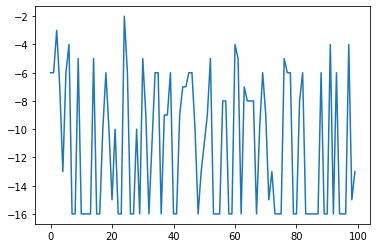

In [19]:
plt.plot(rewards)

In [30]:
obs = env.reset()
goal = obs['goal']
state = obs['state']
print(obs)
done = False
while not done:
  action = generate_action(np.concatenate([state,goal]), 0)
  obs, reward, done, _ = env.step(action)
  goal = obs['goal']
  next_state = obs['state']

  print('\nstate is:', state, 'goal is:', goal, 'action is:', action, 'next_state is:', next_state , 'reward is:', reward)
  state = next_state

{'state': array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]), 'goal': array([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1])}

state is: [1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1] goal is: [1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1] action is: 7 next_state is: [1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1] reward is: -1

state is: [1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1] goal is: [1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1] action is: 12 next_state is: [1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1] reward is: -1

state is: [1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1] goal is: [1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1] action is: 10 next_state is: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1] reward is: -1

state is: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1] goal is: [1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1] action is: 6 next_state is: [1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1] reward is: -1

state is: [1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1] goal is: [1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1] action is: 14 next_state is: [1 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1] reward is: -1

state is: [1 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1] 

In [14]:
r

array([0, 0, 0])

In [15]:
r

({'goal': array([0, 0, 0]), 'state': array([1, 1, 0])}, -1, False, {})

In [22]:
v = list(r[0].values())

In [24]:
np.concatenate([v[0],v[1]])

array([1, 1, 0, 0, 0, 0])

In [23]:
v

[array([1, 1, 0]), array([0, 0, 0])]

In [29]:
g =r[0]['goal']

In [27]:
b.reset()

{'goal': array([1, 1, 0]), 'state': array([1, 0, 1])}

In [30]:
n = r[0]['state']

In [36]:
all(g==n)

False